In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import scipy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

Part 1: Data Wrangling
===

In [2]:
# load data from csv
data = pd.read_csv('./data/Spotify-2000.csv')

# convert Length (Duration) column to int64 and relabel with units
data['Length (Duration)'] = data['Length (Duration)'].str.replace(",", "")
data['Length (Duration)'] = data['Length (Duration)'].astype('int64')
data = data.rename(columns={'Length (Duration)': 'Duration (Seconds)'})

# display summary information
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Index                   1994 non-null   int64 
 1   Title                   1994 non-null   object
 2   Artist                  1994 non-null   object
 3   Top Genre               1994 non-null   object
 4   Year                    1994 non-null   int64 
 5   Beats Per Minute (BPM)  1994 non-null   int64 
 6   Energy                  1994 non-null   int64 
 7   Danceability            1994 non-null   int64 
 8   Loudness (dB)           1994 non-null   int64 
 9   Liveness                1994 non-null   int64 
 10  Valence                 1994 non-null   int64 
 11  Duration (Seconds)      1994 non-null   int64 
 12  Acousticness            1994 non-null   int64 
 13  Speechiness             1994 non-null   int64 
 14  Popularity              1994 non-null   int64 
dtypes: i

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Duration (Seconds),Acousticness,Speechiness,Popularity
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59


Part 2: Exploratory Data Analysis
===

In [3]:
# create dictionary of word frequency in genre
categories = {}
for genre in data['Top Genre']:
    words = genre.split(' ')
    for word in words:
        if word in categories:
            categories[word] += 1
        else:
            categories[word] = 1

# sort dictionary by frequency to get most common overall genre categories
list({k: v for k, v in sorted(categories.items(), key=lambda item: item[1], reverse=True)}.items())[:8]

[('rock', 856),
 ('album', 413),
 ('pop', 344),
 ('dutch', 266),
 ('alternative', 187),
 ('dance', 151),
 ('adult', 123),
 ('standards', 123)]

In [4]:
# label data with the selected genre categories
for i, row in data.iterrows():
    if "pop" in row['Top Genre']: 
        data.at[i,'Genre Classification'] = 2
    elif "rock" in row['Top Genre']:
        data.at[i,'Genre Classification'] = 1
    else: 
        data.at[i,'Genre Classification'] = 0

# TODO: Deal with pop rock and metal 

# display
data.head(8)

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Duration (Seconds),Acousticness,Speechiness,Popularity,Genre Classification
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71,0.0
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39,1.0
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69,0.0
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76,0.0
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59,1.0
5,6,The Road Ahead (Miles Of The Unknown),City To City,alternative pop rock,2004,99,46,54,-9,14,14,247,0,2,45,2.0
6,7,She Will Be Loved,Maroon 5,pop,2002,102,71,71,-6,13,54,257,6,3,74,2.0
7,8,Knights of Cydonia,Muse,modern rock,2006,137,96,37,-5,12,21,366,0,14,69,1.0


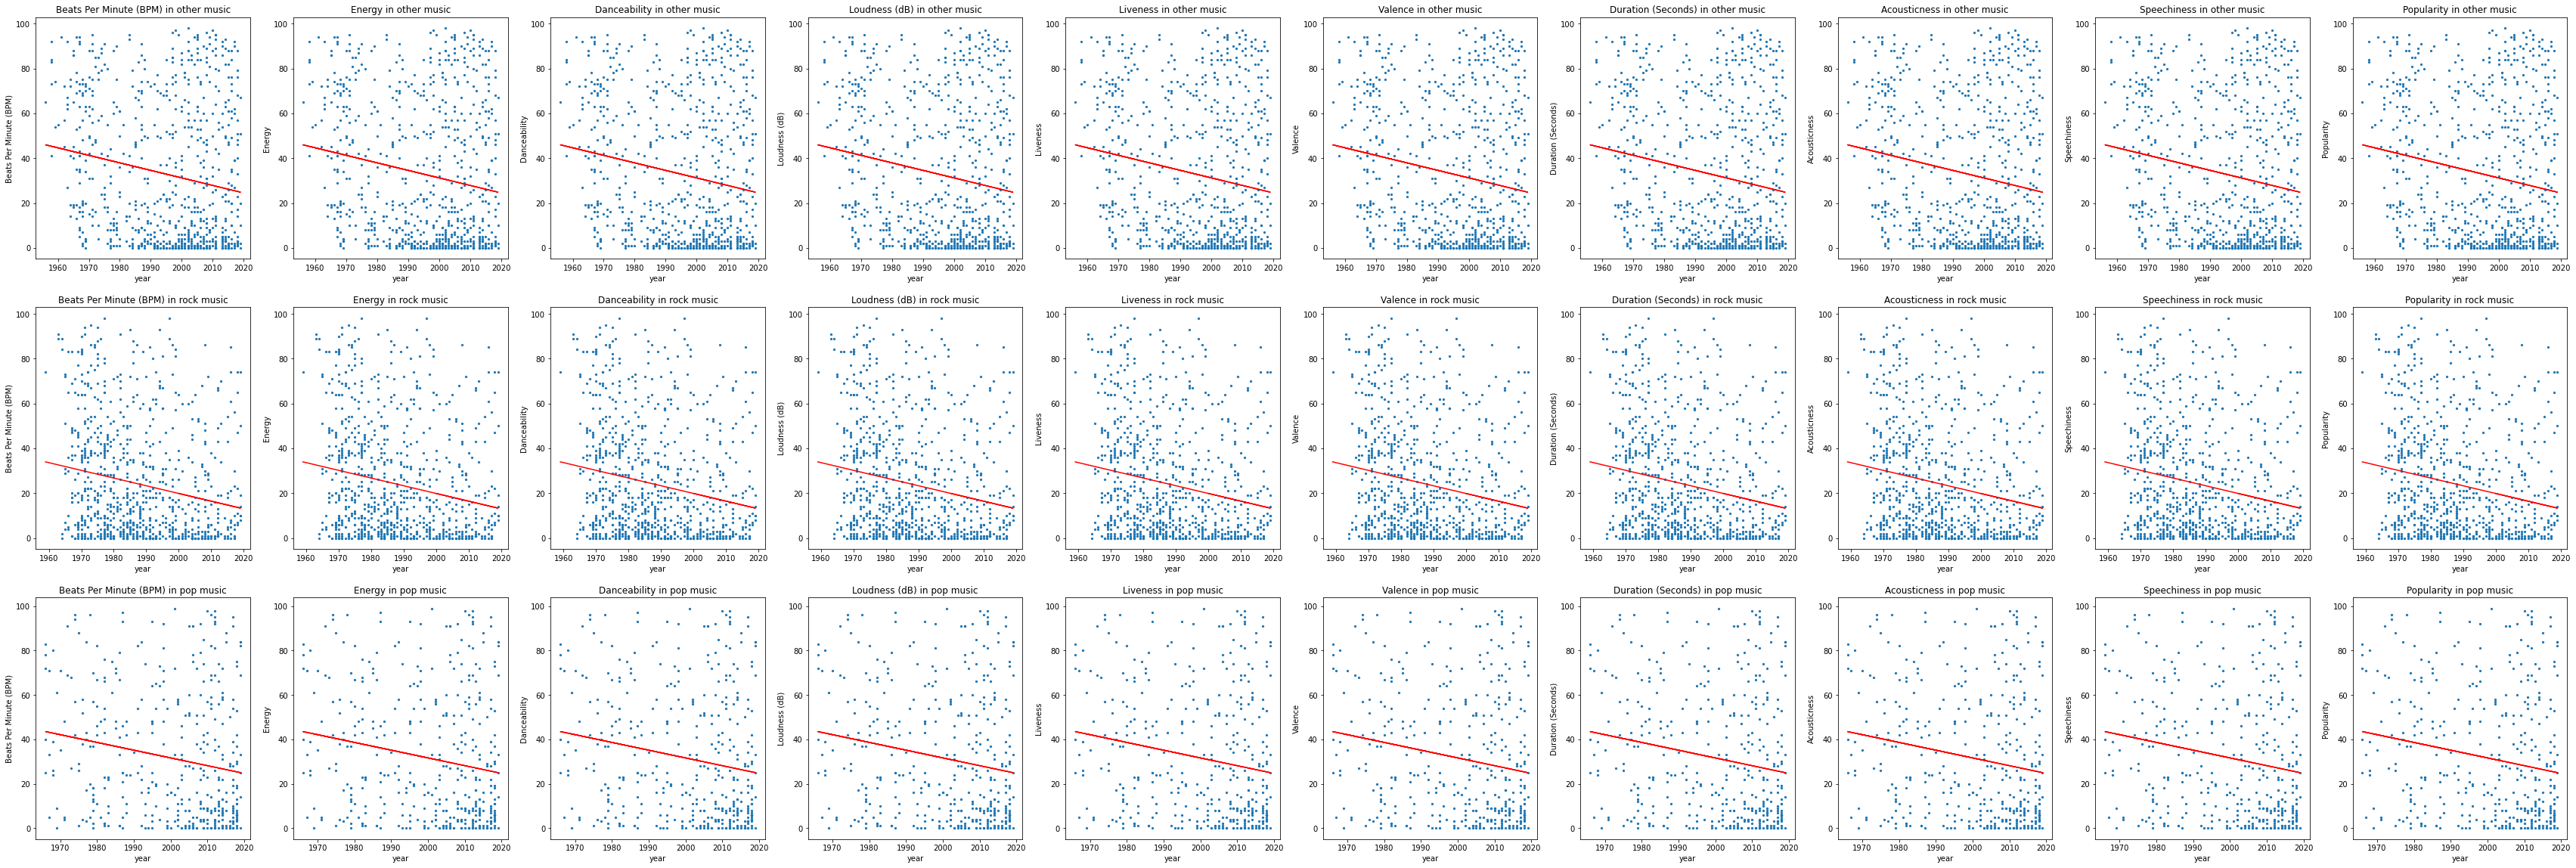

In [5]:
features = data.columns[5:15]
fig, ax = plt.subplots(3,10,figsize=(60,20))
# plt.subplots_adjust(hspace=1.2)
for i, feature in enumerate(features):

    for genre in range(0,3):
        lm = linear_model.LinearRegression()

        frame = data[data['Genre Classification'] == genre]
        x = pd.DataFrame(frame['Year'])
        y = pd.DataFrame(frame['Acousticness'])

        lm.fit(x,y)

        ax[genre, i].scatter(x,y,s=5)

        genre_name =''
        if genre == 2.0:
            genre_name = "pop"
        elif genre == 1.0:
            genre_name = "rock"
        else:
            genre_name = "other"

        ax[genre, i].set_xlabel("year")
        ax[genre, i].set_ylabel(feature)
        ax[genre, i].set_title(f'{feature} in {genre_name} music')

        ax[genre, i].plot(x, lm.predict(x), color='red')

# Part 3: Hypothesis Testing

In [6]:
data = pd.read_csv('../data/Billboard_Audio_Features.csv')
data = data.dropna()
data.head()

,Album ID,Artist IDs,Artist(s),ID,Popularity,Query,Rank,Release Date,Song,Year,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Primary Artist ID,Genres,Top Genre
0,3bbdZdZQtCtnWEN5zG7Eyj,'3Z02hBLubJxuFJfhacLSDc',Bryan Adams,5HQ6AUDMbMuwktvcNPuV1y,36.0,track:(Everything I Do) I Do It for You artist...,1.0,1991-01-01,(Everything I Do) I Do It for You,1991.0,...,0.06480,0.000013,0.0550,0.273,131.189,398027,4,3Z02hBLubJxuFJfhacLSDc,"album rock, canadian pop, canadian singer-song...",rock
1,4zhigAhPwqp43XVHBiVeQI,'7xTcuBOIAAIGDOSvwYFPzk',Daniel Powter,0mUyMawtxj1CJ76kn9gIZK,75.0,track:Bad Day artist:Daniel Powter,1.0,2005-02-22,Bad Day,2006.0,...,0.44800,0.003360,0.1510,0.520,140.046,233640,4,7xTcuBOIAAIGDOSvwYFPzk,"canadian pop, neo mellow, pop rock",pop
2,0jZfbz0dNfDjPSg0hYJNth,'72OaDtakiy6yFqkt4TsiFt',Cher,2goLsvvODILDzeeiT4dAoR,76.0,track:Believe artist:Cher,1.0,1998-01-01,Believe,1999.0,...,0.00820,0.000000,0.0509,0.459,132.975,239027,4,72OaDtakiy6yFqkt4TsiFt,"dance pop, hollywood, new wave pop, pop, pop rock",pop
3,2Jmuuw5ff8gAGAP6B1yKKJ,'5PN2aHIvLEM98XIorsPMhE',Kim Carnes,0kPeymTUiaidv48eRrMISu,64.0,track:Bette Davis Eyes artist:Kim Carnes,1.0,2007-01-01,Bette Davis Eyes,1981.0,...,0.01740,0.000000,0.1980,0.560,116.685,224693,4,5PN2aHIvLEM98XIorsPMhE,"new wave pop, soft rock",rock
4,4yP0hdKOZPNshxUOjY0cZj,'1Xyo4u8uXC1ZmMpatF05PJ',The Weeknd,0VjIjW4GlUZAMYd2vXMi3b,94.0,track:Blinding Lights artist:The Weeknd,1.0,2020-03-20,Blinding Lights,2020.0,...,0.00146,0.000095,0.0897,0.334,171.005,200040,4,1Xyo4u8uXC1ZmMpatF05PJ,"canadian contemporary r&b, canadian pop, pop",soul/r&b


In [7]:
feature_list = list(data.columns.values)
feature_list = feature_list[10:22]
feature_list

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms']

In [8]:
genre_list = ['hip hop/rap','alternative/indie','country','disco','edm',
             'pop','rock','soul/r&b']
for feature in feature_list:
    genre_frames = []
    for genre in genre_list:
        genre_frames.append(data[data['Top Genre'] == genre][feature])
        
    t, p = scipy.stats.kruskal(genre_frames[0],genre_frames[1],
                              genre_frames[2],genre_frames[3],
                              genre_frames[4],genre_frames[5],
                              genre_frames[6],genre_frames[7])
    print(feature + ": t: " + str(t) + " p-value: " + str(p))
    print("")

danceability: t: 892.0653791458489 p-value: 2.481648369683846e-188

energy: t: 282.5551765302803 p-value: 3.200577495327485e-57

key: t: 22.058580524622368 p-value: 0.0024820045783447127

loudness: t: 846.8851729523643 p-value: 1.4099281667606597e-178

mode: t: 244.82240105668825 p-value: 3.502312772938618e-49

speechiness: t: 1336.3904842714205 p-value: 2.2325501776921572e-284

acousticness: t: 496.36764795999653 p-value: 4.840288930133197e-103

instrumentalness: t: 289.16510404008136 p-value: 1.244030697270327e-58

liveness: t: 34.83952318519514 p-value: 1.1988445159940325e-05

valence: t: 133.88666962789867 p-value: 9.679373519097456e-26

tempo: t: 72.6032348114743 p-value: 4.3927937644712003e-13

duration_ms: t: 171.90173191784524 p-value: 9.970796947188792e-34



In [9]:
X = []
Y = []
for i, row in data.iterrows():
    x = []
    for feature in feature_list:
        x.append(row[feature])
    X.append(x)
    Y.append(row['Top Genre'])

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.30)
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, Y_train);
Y_pred = lda_clf.predict(X_test)
print(metrics.classification_report(Y_test,Y_pred))

                   precision    recall  f1-score   support

alternative/indie       0.22      0.04      0.07        47
          country       0.00      0.00      0.00       181
            disco       0.31      0.20      0.25       128
              edm       0.00      0.00      0.00        48
      hip hop/rap       0.58      0.57      0.58       231
              pop       0.30      0.37      0.33       319
             rock       0.40      0.69      0.51       387
         soul/r&b       0.38      0.33      0.36       287

         accuracy                           0.39      1628
        macro avg       0.28      0.28      0.26      1628
     weighted avg       0.34      0.39      0.35      1628



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# svm_clf = svm.SVC(kernel='linear', C=0.1, gamma = 1)
# svm_scores = cross_val_score(svm_clf, X, Y, cv=10, scoring='accuracy')
lda_clf = LinearDiscriminantAnalysis()
lda_scores = cross_val_score(lda_clf, X, Y, cv=10, scoring='accuracy')

In [12]:
lda_scores

array([0.3572744 , 0.34990792, 0.38305709, 0.38305709, 0.40590406,
       0.38560886, 0.41697417, 0.4298893 , 0.39667897, 0.38191882])

In [13]:
data = data[data['Top Genre'] != "country"]
data = data[data['Top Genre'] != "edm"]

X = []
Y = []
for i, row in data.iterrows():
    x = []
    for feature in feature_list:
        x.append(row[feature])
    X.append(x)
    Y.append(row['Top Genre'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.30)
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, Y_train);
Y_pred = lda_clf.predict(X_test)
print(metrics.classification_report(Y_test,Y_pred))

                   precision    recall  f1-score   support

alternative/indie       0.43      0.06      0.11        47
            disco       0.49      0.20      0.28       128
      hip hop/rap       0.65      0.57      0.61       231
              pop       0.37      0.41      0.39       319
             rock       0.49      0.67      0.57       387
         soul/r&b       0.40      0.34      0.36       287

         accuracy                           0.46      1399
        macro avg       0.47      0.38      0.39      1399
     weighted avg       0.47      0.46      0.45      1399



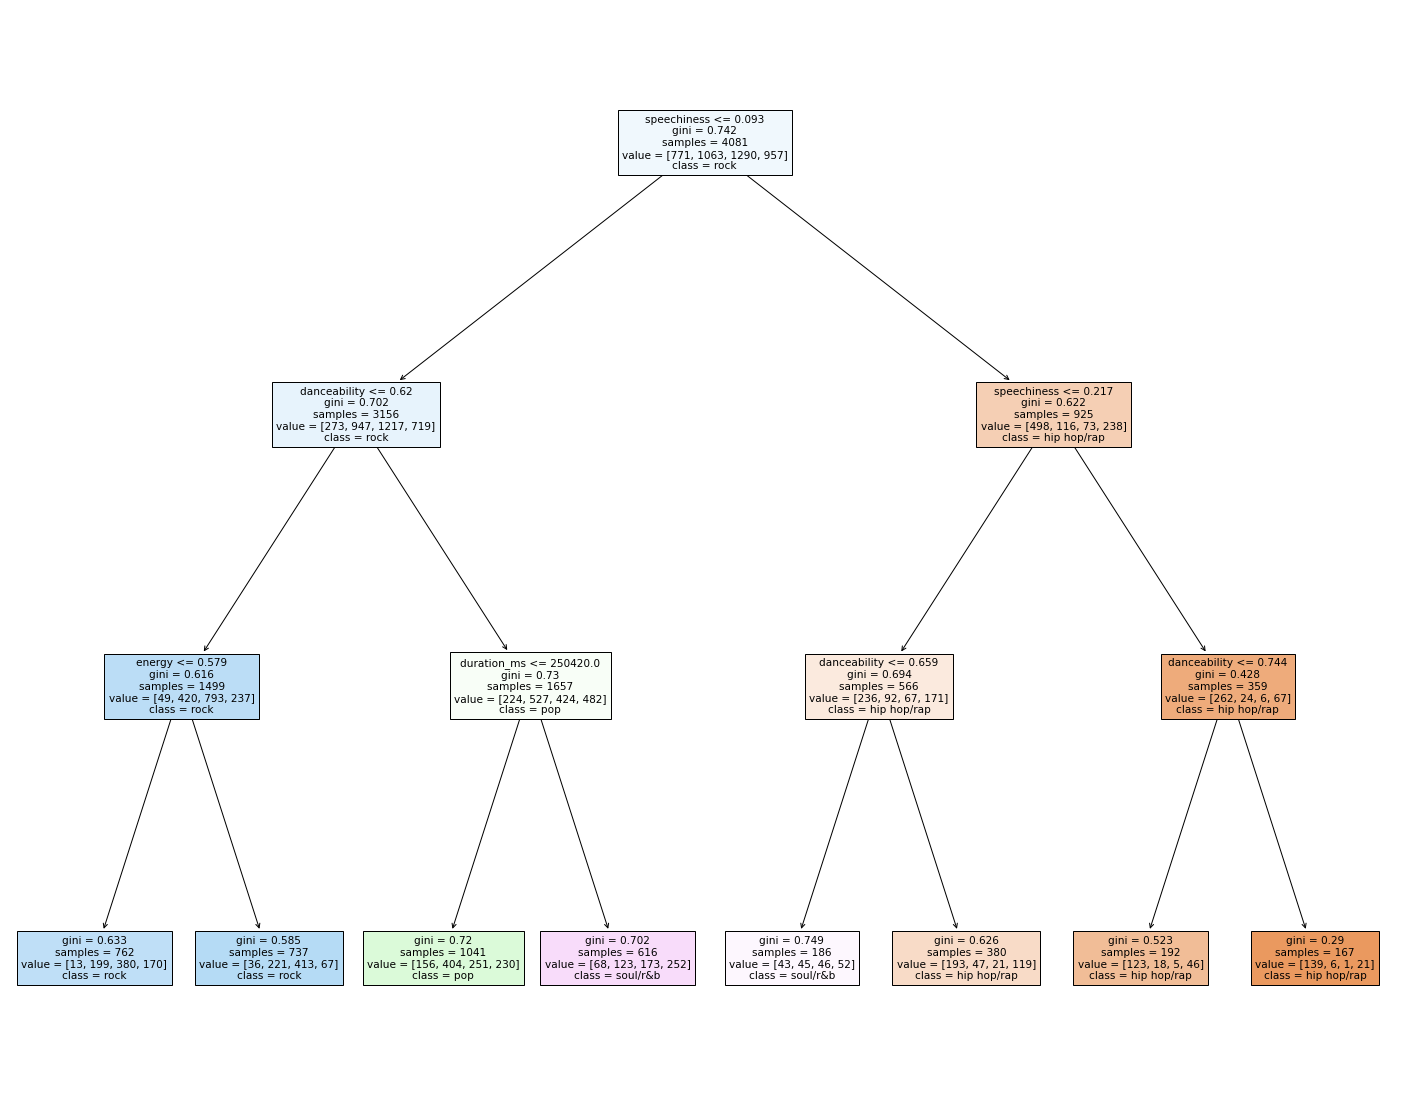

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

data = data[data['Top Genre'] != "disco"]
data = data[data['Top Genre'] != "alternative/indie"]

feature_list = list(data.columns.values)
feature_list = feature_list[10:22]
feature_list.remove("liveness")
feature_list.remove("valence")
feature_list.remove("acousticness")
feature_list.remove("instrumentalness")
feature_list.remove("mode")
feature_list.remove("loudness")
feature_list.remove("key")

genre_list = ['hip hop/rap',
             'pop','rock','soul/r&b']

X = []
Y = []
for i, row in data.iterrows():
    x = []
    for feature in feature_list:
        x.append(row[feature])
    X.append(x)
    Y.append(row['Top Genre'])



clf = DecisionTreeClassifier(max_depth=3)
model = clf.fit(X, Y)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=feature_list,
                   class_names=genre_list,
                   filled=True)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.30)
clf = DecisionTreeClassifier(max_depth=3)
model = clf.fit(X, Y)
Y_pred = clf.predict(X_test)
print(metrics.classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

 hip hop/rap       0.63      0.57      0.60       232
         pop       0.39      0.40      0.40       319
        rock       0.53      0.59      0.56       387
    soul/r&b       0.40      0.36      0.38       287

    accuracy                           0.48      1225
   macro avg       0.49      0.48      0.48      1225
weighted avg       0.48      0.48      0.48      1225

